# Computer vision, konwolucyjna architektura kodu i sieć klasyfikacyjna

In [3]:
#Torch
import torch
from torch import nn
#Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
#Misc
import matplotlib.pyplot as plt
#Progresbar
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparametry

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01

## 1.Przygotowanie danych wejściowych 
Dataset FashionMNIST

In [5]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

### Wizualizacja danych

(-0.5, 27.5, 27.5, -0.5)

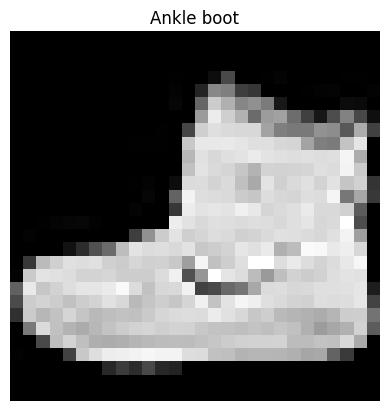

In [6]:
img_index = 0
plt.imshow(train_data[img_index][0].permute(1, 2, 0), cmap='gray')
plt.title(train_data.classes[train_data[img_index][1]])
plt.axis(False)

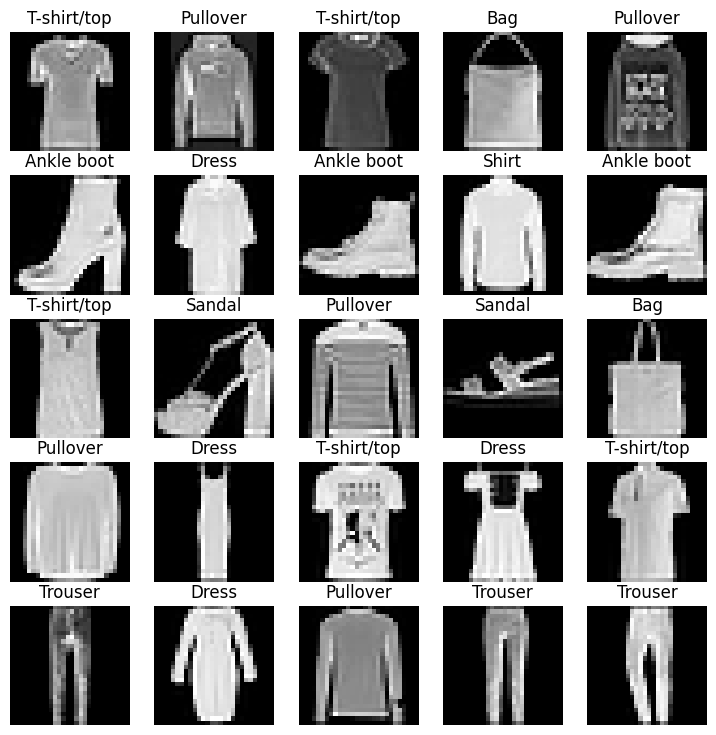

In [7]:
fig = plt.figure(figsize=(9,9))
rows, columns = 5, 5
for i in range(1, rows*columns+1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

### Data loader
Żeby uczyć model mini batchami

In [8]:
train_dataLoader = torch.utils.data.DataLoader(dataset=train_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)
test_dataLoader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)

print(f"Train dataLoader: {len(train_dataLoader)} batches of {BATCH_SIZE}")
print(f"Test dataLoader: {len(test_dataLoader)} batches of {BATCH_SIZE}")

Train dataLoader: 1875 batches of 32
Test dataLoader: 313 batches of 32


### Przykładowe zdjęcie z batcha

In [9]:
#Wrzucenie iteracja batcha do RAMu
train_images_batch, train_labels_batch = next(iter(train_dataLoader))
train_images_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

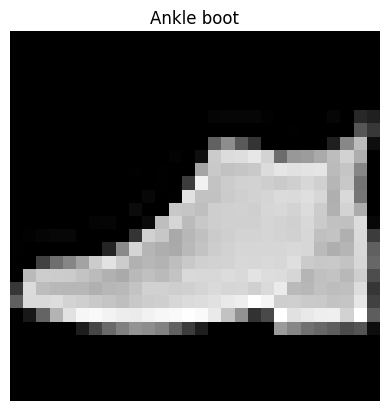

In [10]:
rand_index = torch.randint(0, len(train_images_batch), size=[1]).item()
image, label = train_images_batch[rand_index], train_labels_batch[rand_index]
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title(train_data.classes[label])
plt.axis(False)

## 2. Model sieci

In [11]:
class ComputerVisionModelV1(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

modelV1 = ComputerVisionModelV1(input_shape=784, hidden_units=32, output_shape=len(train_data.classes)).to(device)

#Loss and optimizer
optimizer = torch.optim.Adam(params=modelV1.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()

### Funkcja wyliczająca celność

In [12]:
#Funkcja wyliczająca dokładność sieci
def accuracy(pred, target):
    return (torch.eq(pred, target).sum().item()/len(pred))*100

### Funkcja wyliczająca czas działania

In [13]:
from timeit import default_timer as timer
def print_train_time(start: float,
                    end: float):
    total_time = end - start
    print(f"Train time: {total_time:.4f} seconds")
    return total_time

## 3. Pętla treningowa

In [14]:
epochs = 10

#Start training
total_time_start = timer()
for epoch in tqdm(range(epochs)):
    #Start timer
    start_time = timer()
    print(f"\nEpoch: {epoch}\n------")
    #____Trening____
    train_loss = 0
    for batch, (image, label) in enumerate(train_dataLoader):
        image = image.to(device)
        label = label.to(device)
        modelV1.train()
        #1. Forward
        logits = modelV1(image)
        #2. Loss
        loss = loss_func(logits, label)
        train_loss += loss #Koszt dla całego epochu
        acc = accuracy(torch.argmax(torch.softmax(logits,dim=1), dim=1), label) #Celność
        #3. Zero grad
        optimizer.zero_grad()
        #4. Backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
        
        if batch%300 == 0:
            print(f"Looked through: {batch*BATCH_SIZE}/{len(train_dataLoader.dataset)} elements.")
    
    train_loss = train_loss/len(train_dataLoader)
    
    #___Testing___
    modelV1.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for images, labels in test_dataLoader:
            images = images.to(device)
            labels = labels.to(device)
            #Forward
            test_logits = modelV1(images)
            
            #Koss
            test_loss += loss_func(test_logits, labels)
            
            #Celność
            test_acc += accuracy(torch.argmax(torch.softmax(test_logits,dim=1), dim=1), labels)
            
        #Koszt dla całego testu
        test_loss = test_loss/len(test_dataLoader)
        test_acc = test_acc/len(test_dataLoader)
        
    #Wypisz info
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
    
    #zakończ timer
    end_time = timer()
    print_train_time(start_time, end_time)
total_time_end = timer()
total_time_modelV1 = total_time_end - total_time_start

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Epoch: 0
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 10%|████████▎                                                                          | 1/10 [00:12<01:48, 12.05s/it]


Train loss: 0.5768 | Test loss: 0.5286 | Test acc: 81.90
Train time: 12.0507 seconds

Epoch: 1
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 20%|████████████████▌                                                                  | 2/10 [00:21<01:23, 10.38s/it]


Train loss: 0.4713 | Test loss: 0.4598 | Test acc: 83.79
Train time: 9.2082 seconds

Epoch: 2
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 30%|████████████████████████▉                                                          | 3/10 [00:30<01:09,  9.92s/it]


Train loss: 0.4426 | Test loss: 0.5068 | Test acc: 82.38
Train time: 9.3670 seconds

Epoch: 3
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 40%|█████████████████████████████████▏                                                 | 4/10 [00:39<00:57,  9.63s/it]


Train loss: 0.4310 | Test loss: 0.4692 | Test acc: 83.97
Train time: 9.1914 seconds

Epoch: 4
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:49<00:47,  9.48s/it]


Train loss: 0.4156 | Test loss: 0.4893 | Test acc: 82.86
Train time: 9.2115 seconds

Epoch: 5
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:58<00:37,  9.39s/it]


Train loss: 0.4183 | Test loss: 0.4526 | Test acc: 84.90
Train time: 9.2041 seconds

Epoch: 6
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:07<00:27,  9.31s/it]


Train loss: 0.3985 | Test loss: 0.5278 | Test acc: 81.84
Train time: 9.1413 seconds

Epoch: 7
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:16<00:18,  9.25s/it]


Train loss: 0.4057 | Test loss: 0.4585 | Test acc: 84.20
Train time: 9.1235 seconds

Epoch: 8
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:25<00:09,  9.19s/it]


Train loss: 0.3941 | Test loss: 0.4603 | Test acc: 84.37
Train time: 9.0718 seconds

Epoch: 9
------
Looked through: 0/60000 elements.
Looked through: 9600/60000 elements.
Looked through: 19200/60000 elements.
Looked through: 28800/60000 elements.
Looked through: 38400/60000 elements.
Looked through: 48000/60000 elements.
Looked through: 57600/60000 elements.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.50s/it]


Train loss: 0.3873 | Test loss: 0.4407 | Test acc: 84.76
Train time: 9.3952 seconds


## 4. Testowanie modelu V1

In [15]:
#Funkcja do ewaluacji modelu
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              accuracy_func,
              device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X = X.to(device)
            y = y.to(device)
            #forward pass
            preds = model(X)
            #Koszt i celność
            loss += loss_func(preds, y)
            acc += accuracy_func(torch.argmax(preds, dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"Model_name": model.__class__.__name__,
           "Loss": loss.item(),
           "Accuracy": acc}

eval_model(modelV1, test_dataLoader, loss_func, accuracy)
    

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 326.52it/s]


{'Model_name': 'ComputerVisionModelV1',
 'Loss': 0.4406648576259613,
 'Accuracy': 84.76437699680511}

## 5. Funkcja do trenowania modelu

In [16]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_func,
              device: torch.device = device):
    
    modelV1.train()
    train_loss, train_acc = 0, 0
    
    for batch, (image, label) in enumerate(data_loader):
        image, label = image.to(device), label.to(device)
        #1. Forward
        logits = model(image)
        #2. Loss
        loss = loss_func(logits, label)
        train_loss += loss #Koszt dla całego epochu
        train_acc += accuracy(torch.argmax(torch.softmax(logits,dim=1), dim=1), label) #Celność dla całego epochu
        #3. Zero grad
        optimizer.zero_grad()
        #4. Backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
    
    #Wylicz średni koszt i celność dla całego epocha per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    #Wyświetl dane
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")

In [17]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              accuracy_func,
              device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            #forward pass
            preds = model(X)
            #Koszt i celność
            loss += loss_func(preds, y)
            acc += accuracy_func(torch.argmax(preds, dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    print(f"Test loss: {loss:.4f} | Test acc: {acc:.4f}")

## 6. Konwolucyjna sieć neuronowa

In [34]:
class ConvolutionalComputerVision(nn.Module):
    def __init__(self, input_shape : int, hidden_units: int, output_shape: int):
        super().__init__()
        #Feature extractor nr.1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #Feature extractor nr.2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        #Klasyfikator
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                     out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [35]:
modelV2 = ConvolutionalComputerVision(input_shape=1,
                                     hidden_units=32,
                                     output_shape=len(train_data.classes)).to(device)

In [36]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelV2.parameters(), lr=0.001)

In [37]:
dummy_image = torch.randn(size=(1, 1,28,28))
with torch.inference_mode():
    preds = modelV2(dummy_image.to(device))
preds

tensor([[-0.0339,  0.0251,  0.0268, -0.0732,  0.0027,  0.0314, -0.0065, -0.0328,
          0.0962, -0.0591]], device='cuda:0')

## 7. Trenowanie konwolucyjnej sieci

In [38]:
epochs = 10

total_time_start = timer()
for epoch in range(epochs):
    start_time = timer()
    print(f"\nEpoch: {epoch}\n-----")
    train_step(model=modelV2,
              optimizer=optimizer,
              loss_func=loss_func,
              data_loader=train_dataLoader,
              accuracy_func=accuracy)
    test_step(model=modelV2,
              data_loader=test_dataLoader,
              accuracy_func=accuracy,
              loss_func=loss_func)
    end_time = timer()
    print_train_time(start_time, end_time)
total_time_end = timer()
total_time_modelV2 = total_time_end - total_time_start


Epoch: 0
-----
Train loss: 0.4263 | Train acc: 84.5750
Test loss: 0.3228 | Test acc: 88.6282
Train time: 10.0818 seconds

Epoch: 1
-----
Train loss: 0.2738 | Train acc: 90.1583
Test loss: 0.2696 | Test acc: 90.4153
Train time: 10.0517 seconds

Epoch: 2
-----
Train loss: 0.2336 | Train acc: 91.6350
Test loss: 0.2433 | Test acc: 91.3438
Train time: 9.8517 seconds

Epoch: 3
-----
Train loss: 0.2107 | Train acc: 92.2967
Test loss: 0.2368 | Test acc: 91.5735
Train time: 9.8401 seconds

Epoch: 4
-----
Train loss: 0.1900 | Train acc: 92.9817
Test loss: 0.2286 | Test acc: 91.8730
Train time: 9.7924 seconds

Epoch: 5
-----
Train loss: 0.1769 | Train acc: 93.5450
Test loss: 0.2363 | Test acc: 91.6434
Train time: 9.7036 seconds

Epoch: 6
-----
Train loss: 0.1630 | Train acc: 94.1667
Test loss: 0.2299 | Test acc: 92.0327
Train time: 9.8543 seconds

Epoch: 7
-----
Train loss: 0.1511 | Train acc: 94.3500
Test loss: 0.2333 | Test acc: 92.0627
Train time: 9.8141 seconds

Epoch: 8
-----
Train loss: 0.

### Porównanie modeli

In [39]:
import pandas as pd
modelComparision = pd.DataFrame([eval_model(model=modelV1, loss_func=loss_func, data_loader=test_dataLoader, accuracy_func=accuracy),
                                eval_model(model=modelV2, loss_func=loss_func, data_loader=test_dataLoader, accuracy_func=accuracy)])
modelComparision['Training time'] = ([total_time_modelV1,
                                     total_time_modelV2])
modelComparision

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 292.86it/s]


,Model_name,Loss,Accuracy,Training time
0,ComputerVisionModelV1,0.440665,84.764377,94.973716
1,ConvolutionalComputerVision,0.243785,92.082668,98.588300


## 8. Testowanie sieci

In [40]:
def predict(model: torch.nn.Module,
           data: list,
           device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    for sample in data:
        sample = torch.unsqueeze(sample, dim=0).to(device)
        logits = model(sample)
        preds = torch.argmax(logits, dim=1)
        pred_probs.append(preds.cpu())
        
    return torch.stack(pred_probs).squeeze()

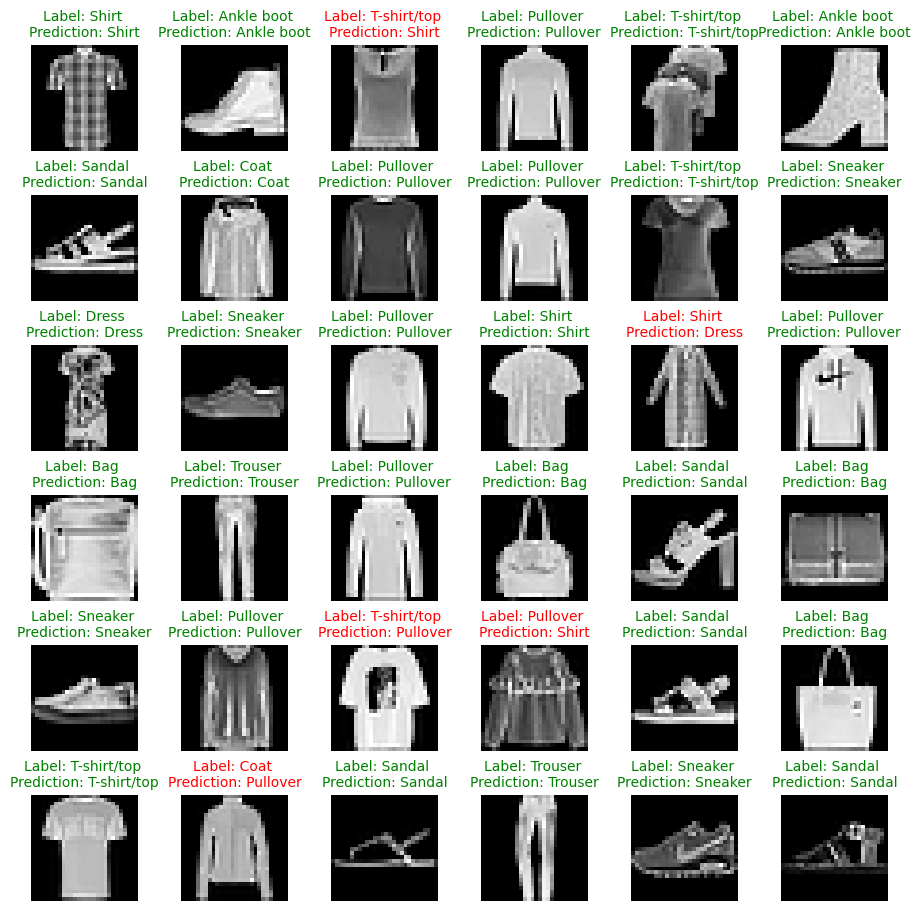

In [77]:
import random
test_samples = []
test_labels = []
rows, columns = 6, 6
for sample, label in random.sample(list(test_data), k=rows*columns):
    test_samples.append(sample)
    test_labels.append(label)
#Create predicitons    
predictions = predict(modelV2, test_samples)

#Display rows * columns random predictions from test data
fig = plt.figure(figsize=(9,9), layout='constrained')

for i in range(0, rows*columns):
    img, label = test_samples[i], test_labels[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    if predictions[i] == test_labels[i]:
        plt.title(f"Label: {test_data.classes[label]} \nPrediction: {test_data.classes[predictions[i]]}", color='green', size=(16-rows))
    else:
        plt.title(f"Label: {test_data.classes[label]} \nPrediction: {test_data.classes[predictions[i]]}", color='red', size=(16-rows))
        
    plt.axis(False)

## 9. Confusion matrix

In [79]:
preds = []
modelV2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataLoader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        preds.append(torch.argmax(torch.softmax(modelV2(X), dim=1), dim=1).cpu())
        
preds = torch.cat(preds)
preds

Making predictions: 100%|███████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 282.34it/s]


10000

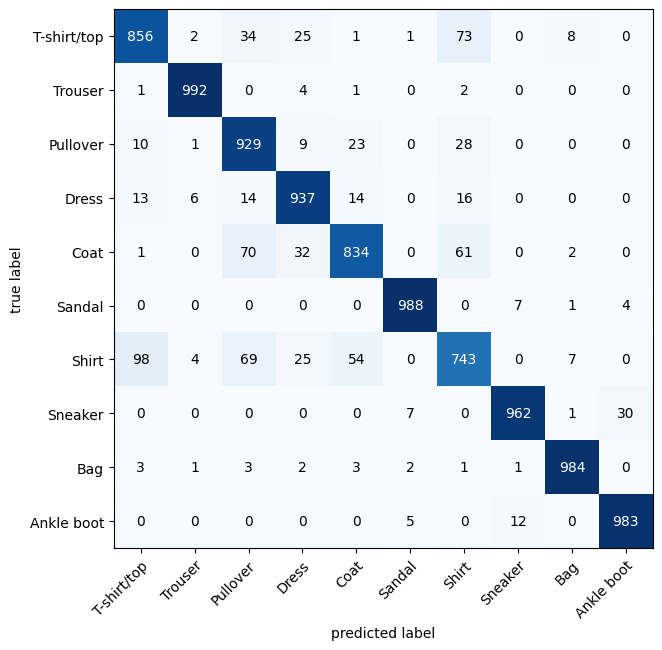

In [87]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = ConfusionMatrix(task='multiclass', num_classes=len(test_data.classes))
conf_mat_tensor = conf_mat(preds=preds,
                          target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10,7)
)

## 10. Zapisywanie modelu

In [93]:
from pathlib import Path
MODEL_NAME = "ConvolutionalFashionMINIST.pt"

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(modelV2.state_dict(), MODEL_SAVE_PATH)

In [97]:
#Create new model and predict
model_loaded = ConvolutionalComputerVision(input_shape=1,
                                          hidden_units=32,
                                          output_shape=len(test_data.classes)).to(device)
before_loading_results = eval_model(model=model_loaded,
                                   loss_func=loss_func,
                                   data_loader=test_dataLoader,
                                   accuracy_func=accuracy)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 280.36it/s]


{'Model_name': 'ConvolutionalComputerVision',
 'Loss': 2.304396629333496,
 'Accuracy': 10.023961661341852}

In [101]:
#Load and predict
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
after_loading_results = eval_model(model=model_loaded,
                                   loss_func=loss_func,
                                   data_loader=test_dataLoader,
                                   accuracy_func=accuracy)
comparision = pd.DataFrame([before_loading_results,
                          after_loading_results])
comparision['Model_name'] = ["Before loading",
                            "After loading"]
comparision

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 285.11it/s]


,Model_name,Loss,Accuracy
0,Before loading,2.304397,10.023962
1,After loading,0.243785,92.082668
